In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms

from tqdm import tqdm
import numpy as np
import os
import pickle
from collections import OrderedDict
import PIL

from celebA_vae import CelebAVAE

In [37]:
dataset_path = './../../datasets/celebA/images/'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(0)
data_dim = (3,64,64)
data_size = np.prod(data_dim)
batch_size = 64

In [38]:
# key word args for loading data
kwargs = {'num_workers': 1, 'pin_memory': True} if device == "cuda" else {}

dataset = datasets.ImageFolder(dataset_path, transform=transforms.ToTensor())
data_size = len(dataset)
train_size = int(0.9 * data_size)
test_size = data_size - train_size
train_set, test_set = torch.utils.data.random_split(dataset, [train_size, test_size])

# load datasets and make them easily fetchable in DataLoaders
train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size, shuffle=True, drop_last=True, **kwargs)

# load datasets and make them easily fetchable in DataLoaders
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size, shuffle=True, drop_last=True, **kwargs)

In [4]:
to_img_torch = transforms.ToPILImage()

def to_img(x):
    img = to_img_torch(x)
    # upsampling. Otherwhgise pdf viewers will fuck with the interpolation
    w, h = img.size
    return img.resize((w*8, h*8), resample=PIL.Image.NEAREST)
    

# Load models

In [5]:
models =OrderedDict()
models['SSIM'] = torch.load('./results/ssim_lam_e12/model.pckl').to(device)
models['Watson-fft'] = torch.load('./results/watson-fft_lam_e0/model.pckl').to(device)
models['Deeploss-vgg'] =  torch.load('./results/watson-fft_lam_e0/model.pckl').to(device) #torch.load('./results/deeploss_lam_e10/model.pckl').to(device)

# Reference

In [87]:
sample_ids = [1, 46, 27, 17, 60, 75, 81, 42]

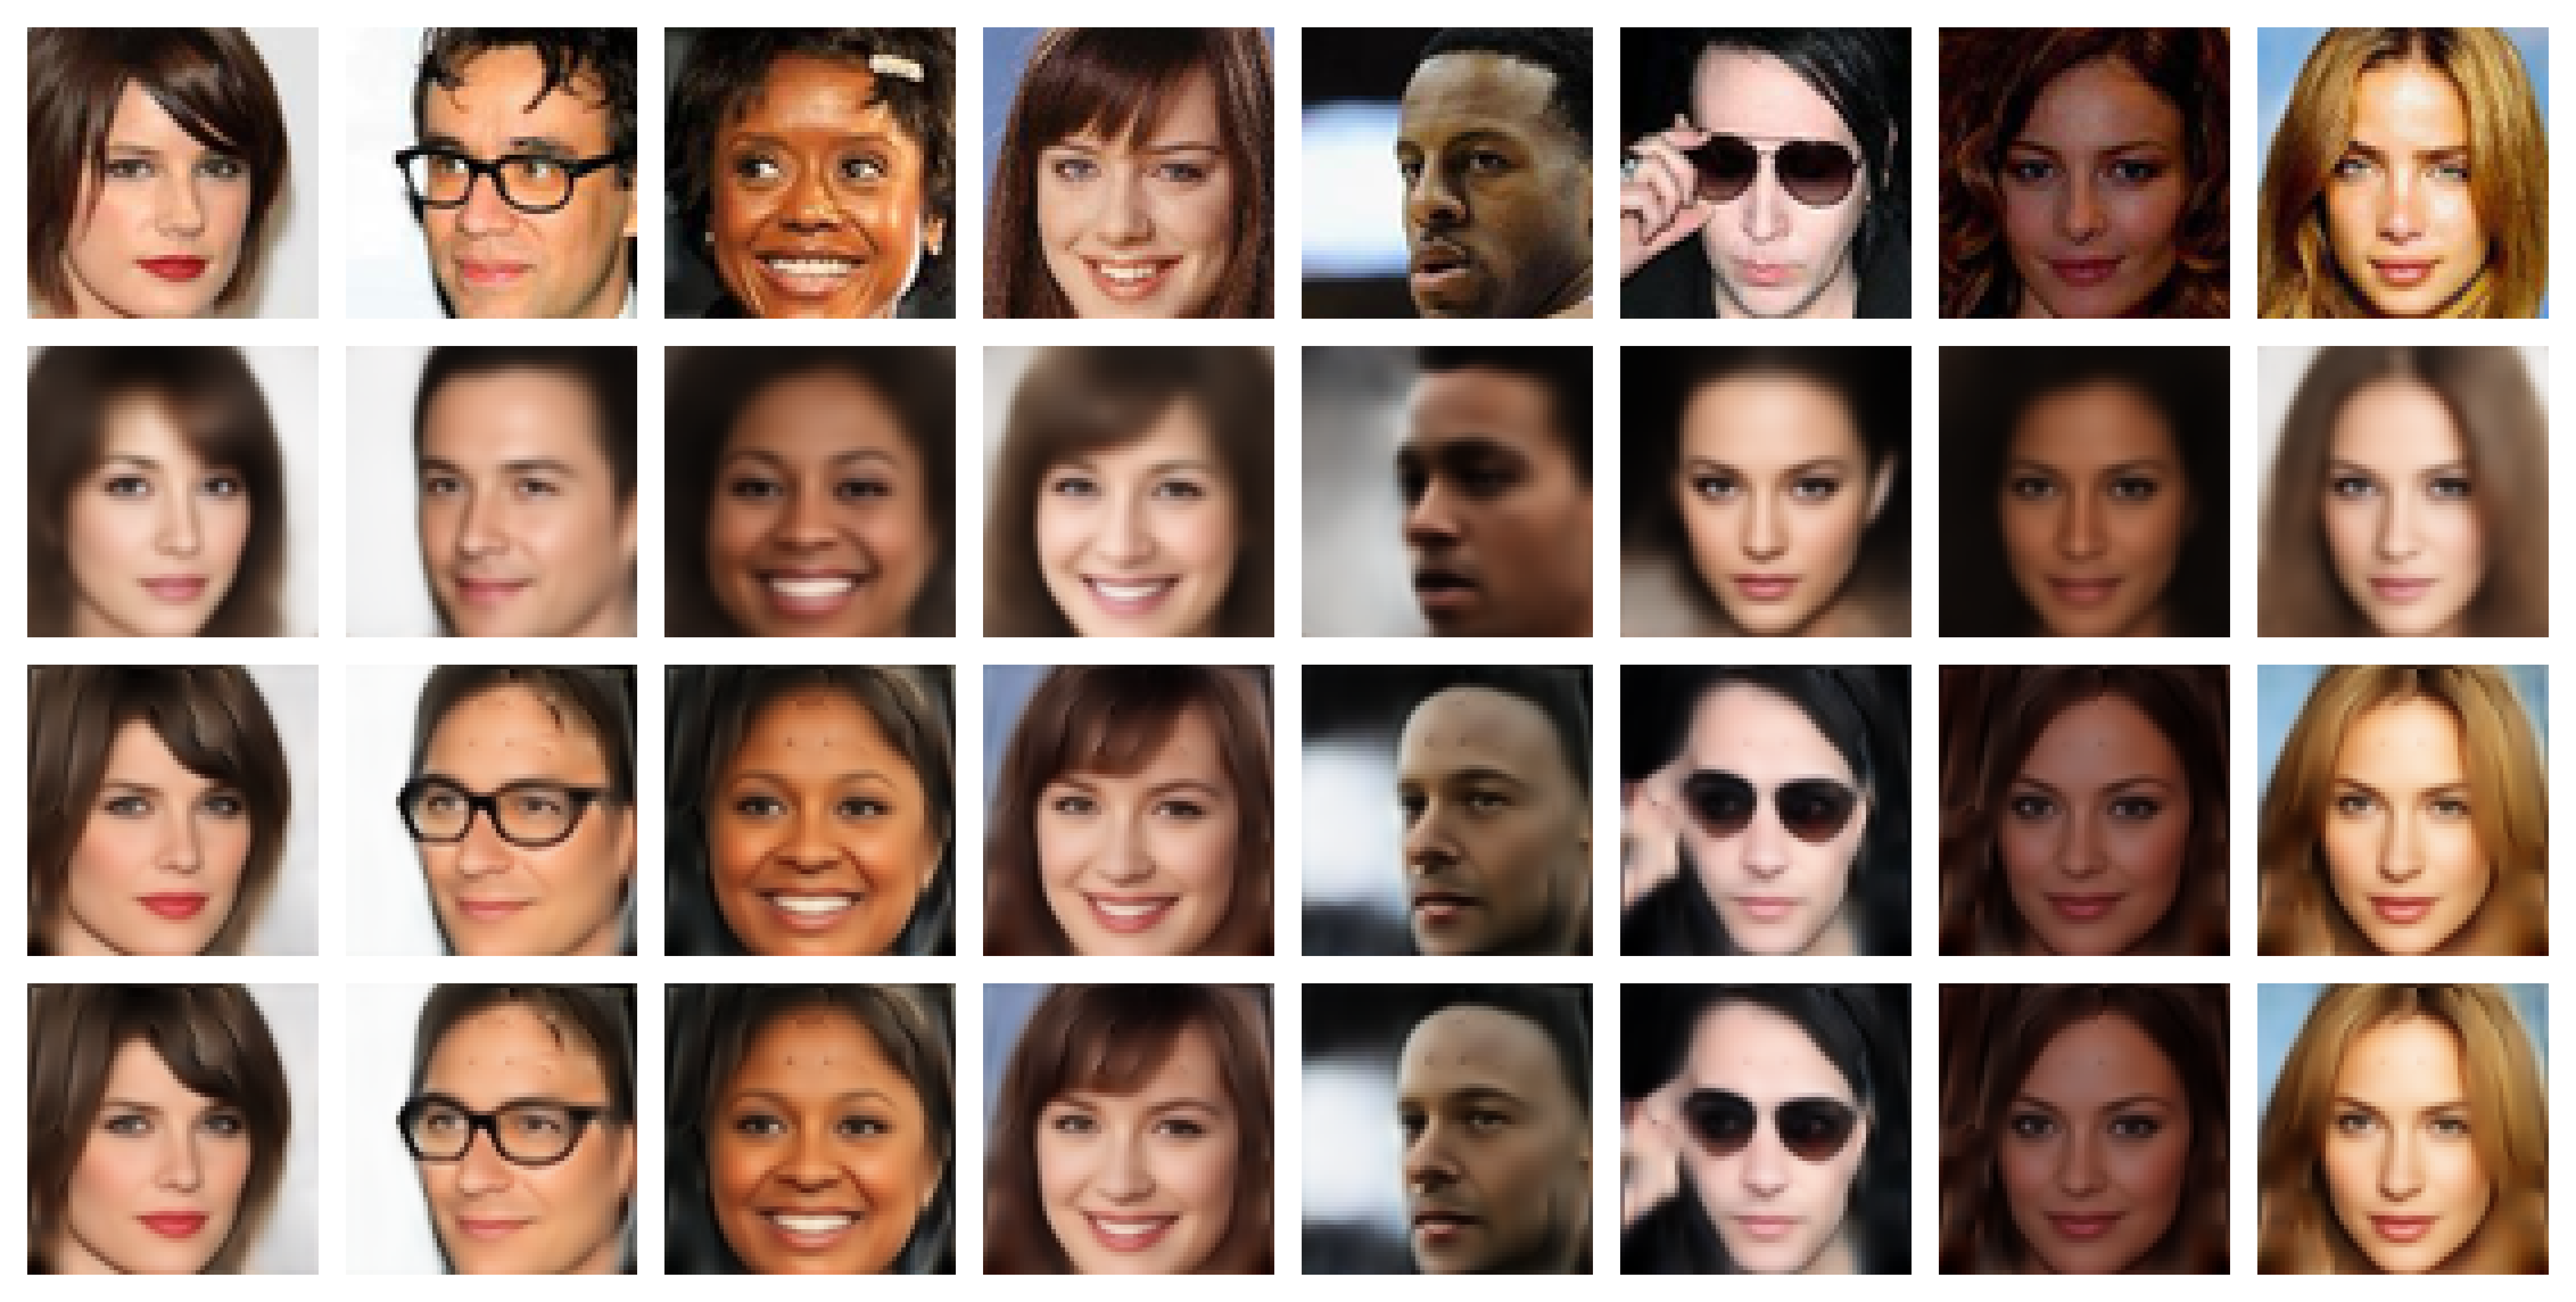

In [113]:
N = 8
#sample reference images
reference = torch.cat([test_set[i][0].expand((1,) + data_dim) for i in sample_ids])

recons = reference.clone().cpu()

for k in models:
    z, _ = models[k].encode(reference.to(device))
    recon = models[k].decode(z)
    recons = torch.cat([recons, recon.cpu()])

grid = torchvision.utils.make_grid(recons, nrow=N, padding=6, pad_value=1)
img = to_img(grid)

img.save('./comparison/celebA_reconstruction.png')

img

# Interpolation

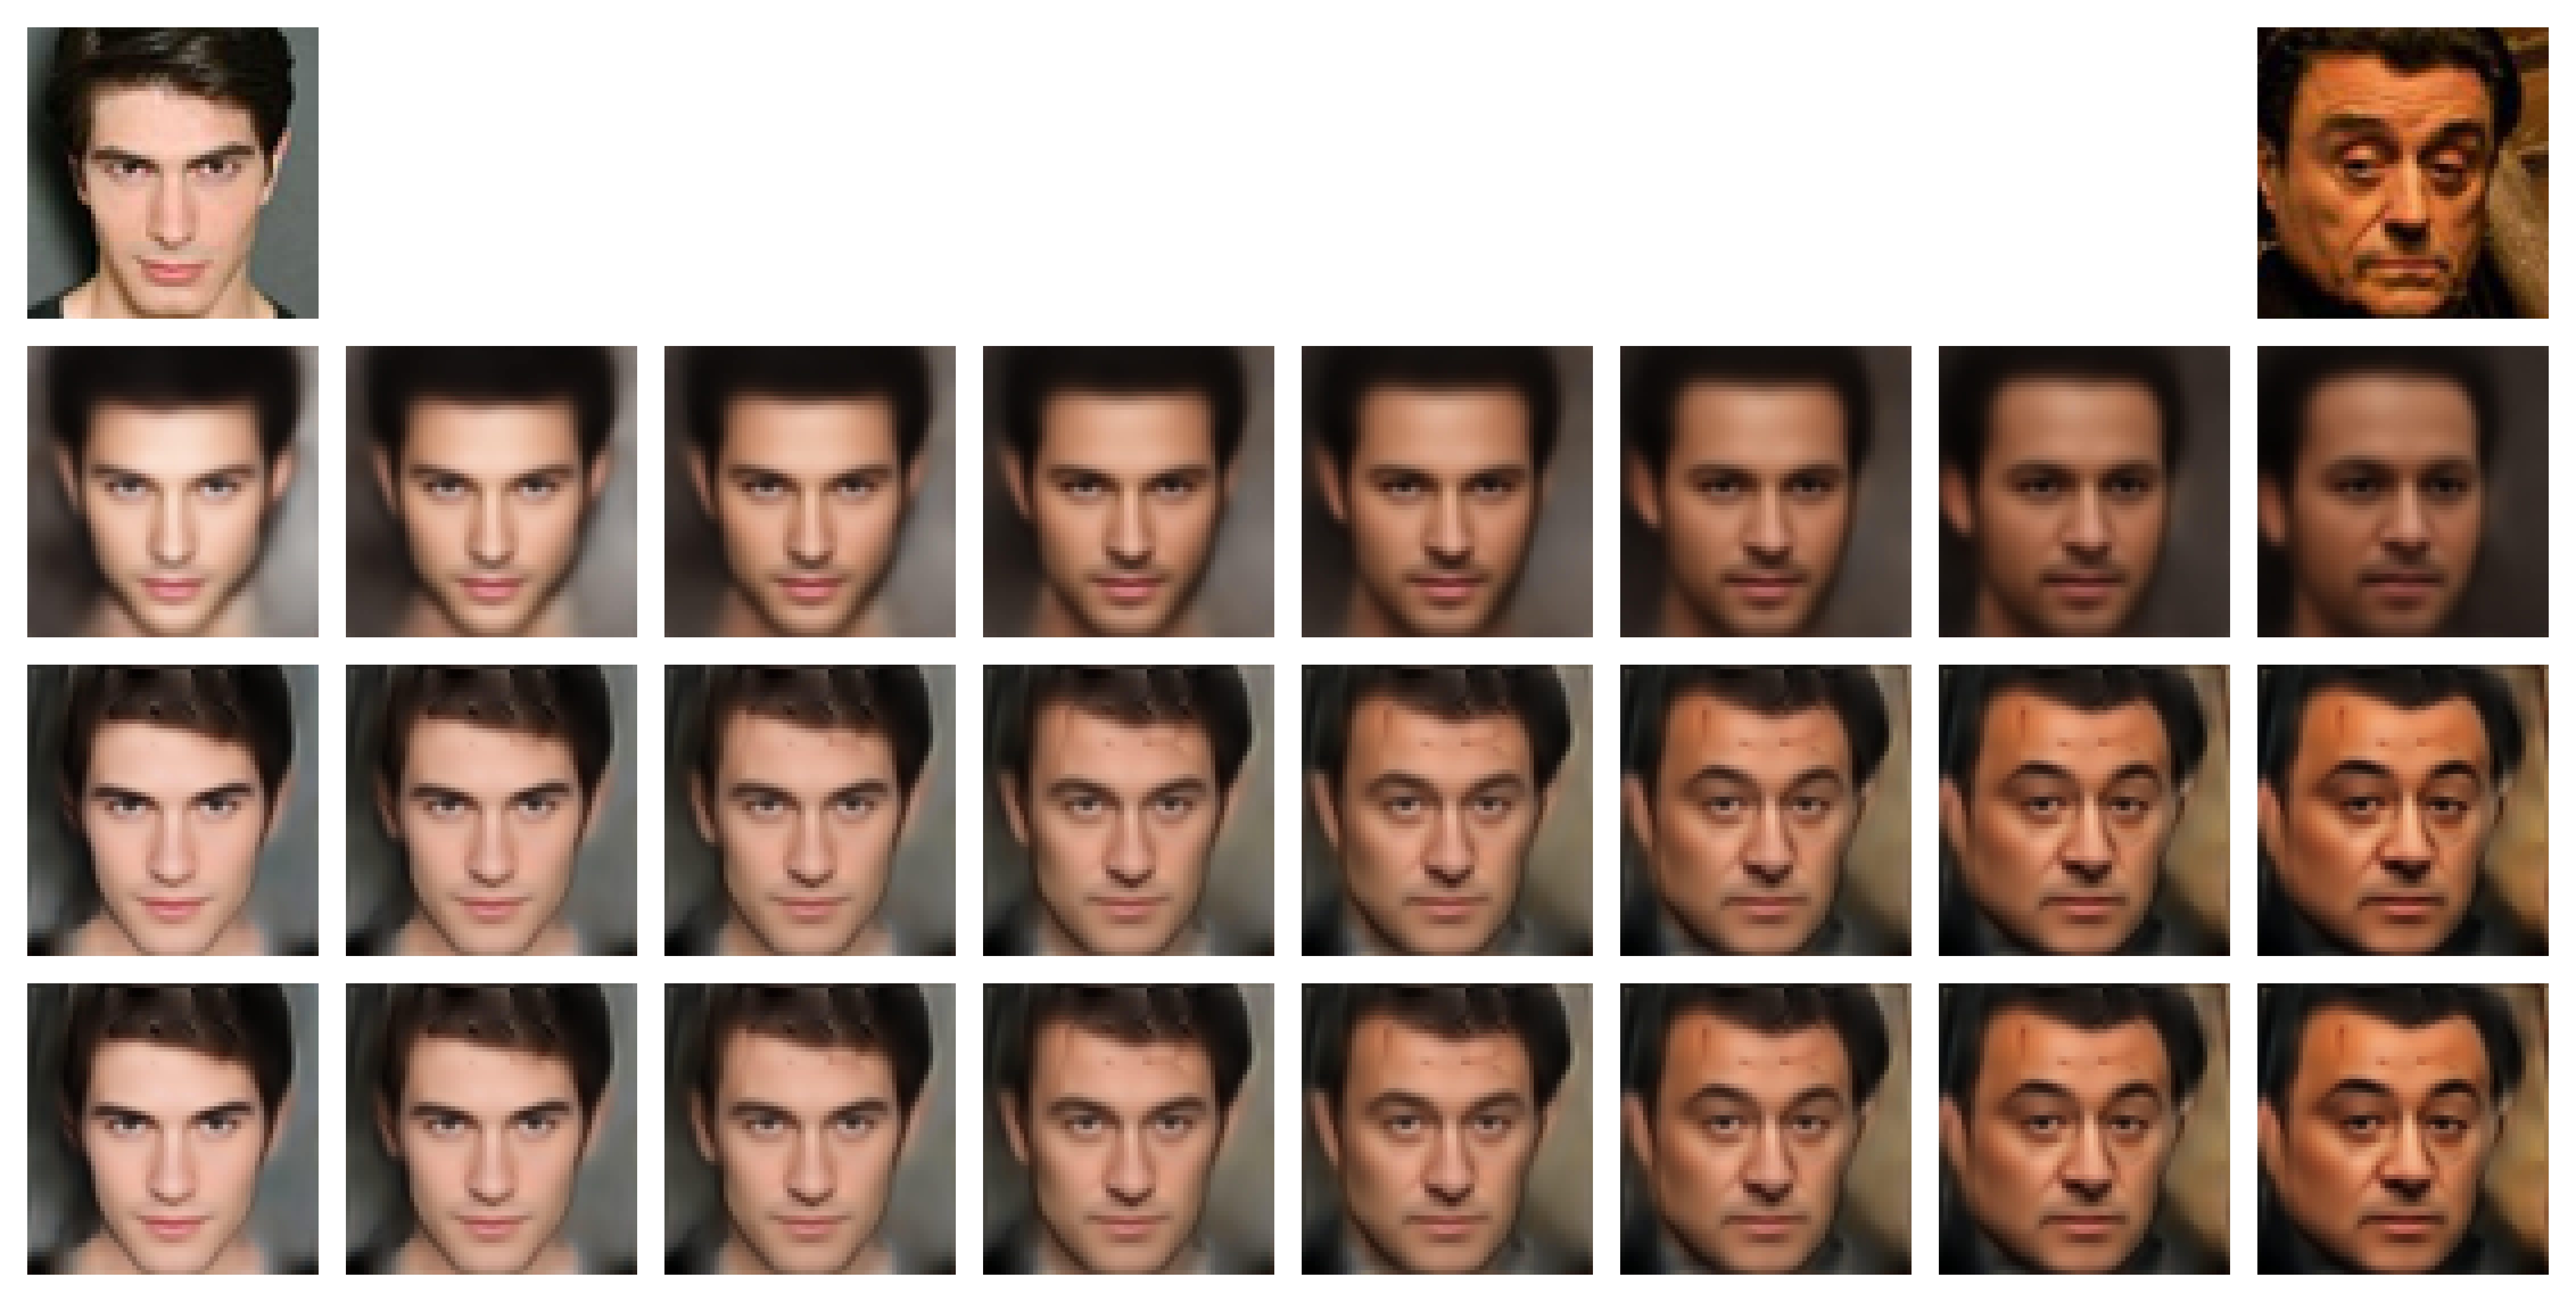

In [160]:
N = 8

s0 = test_set[423][0].expand((1,) + data_dim)
s1 = test_set[664][0].expand((1,) + data_dim)

recons = torch.cat([s0, torch.ones((N-2,) + data_dim) , s1])

for k in models:
    z0, _ = models[k].encode(s0.to(device))
    z1, _ = models[k].encode(s1.to(device))
    zs = torch.cat([n/(N-1) * z1 + (1-n/(N-1)) * z0 for n in range(N)])
    recon = models[k].decode(zs)
    recons = torch.cat([recons, recon.cpu()])

grid = torchvision.utils.make_grid(recons, nrow=N, padding=6, pad_value=1)
img = to_img(grid)

img.save('./comparison/celebA_interpolation0.png')

img

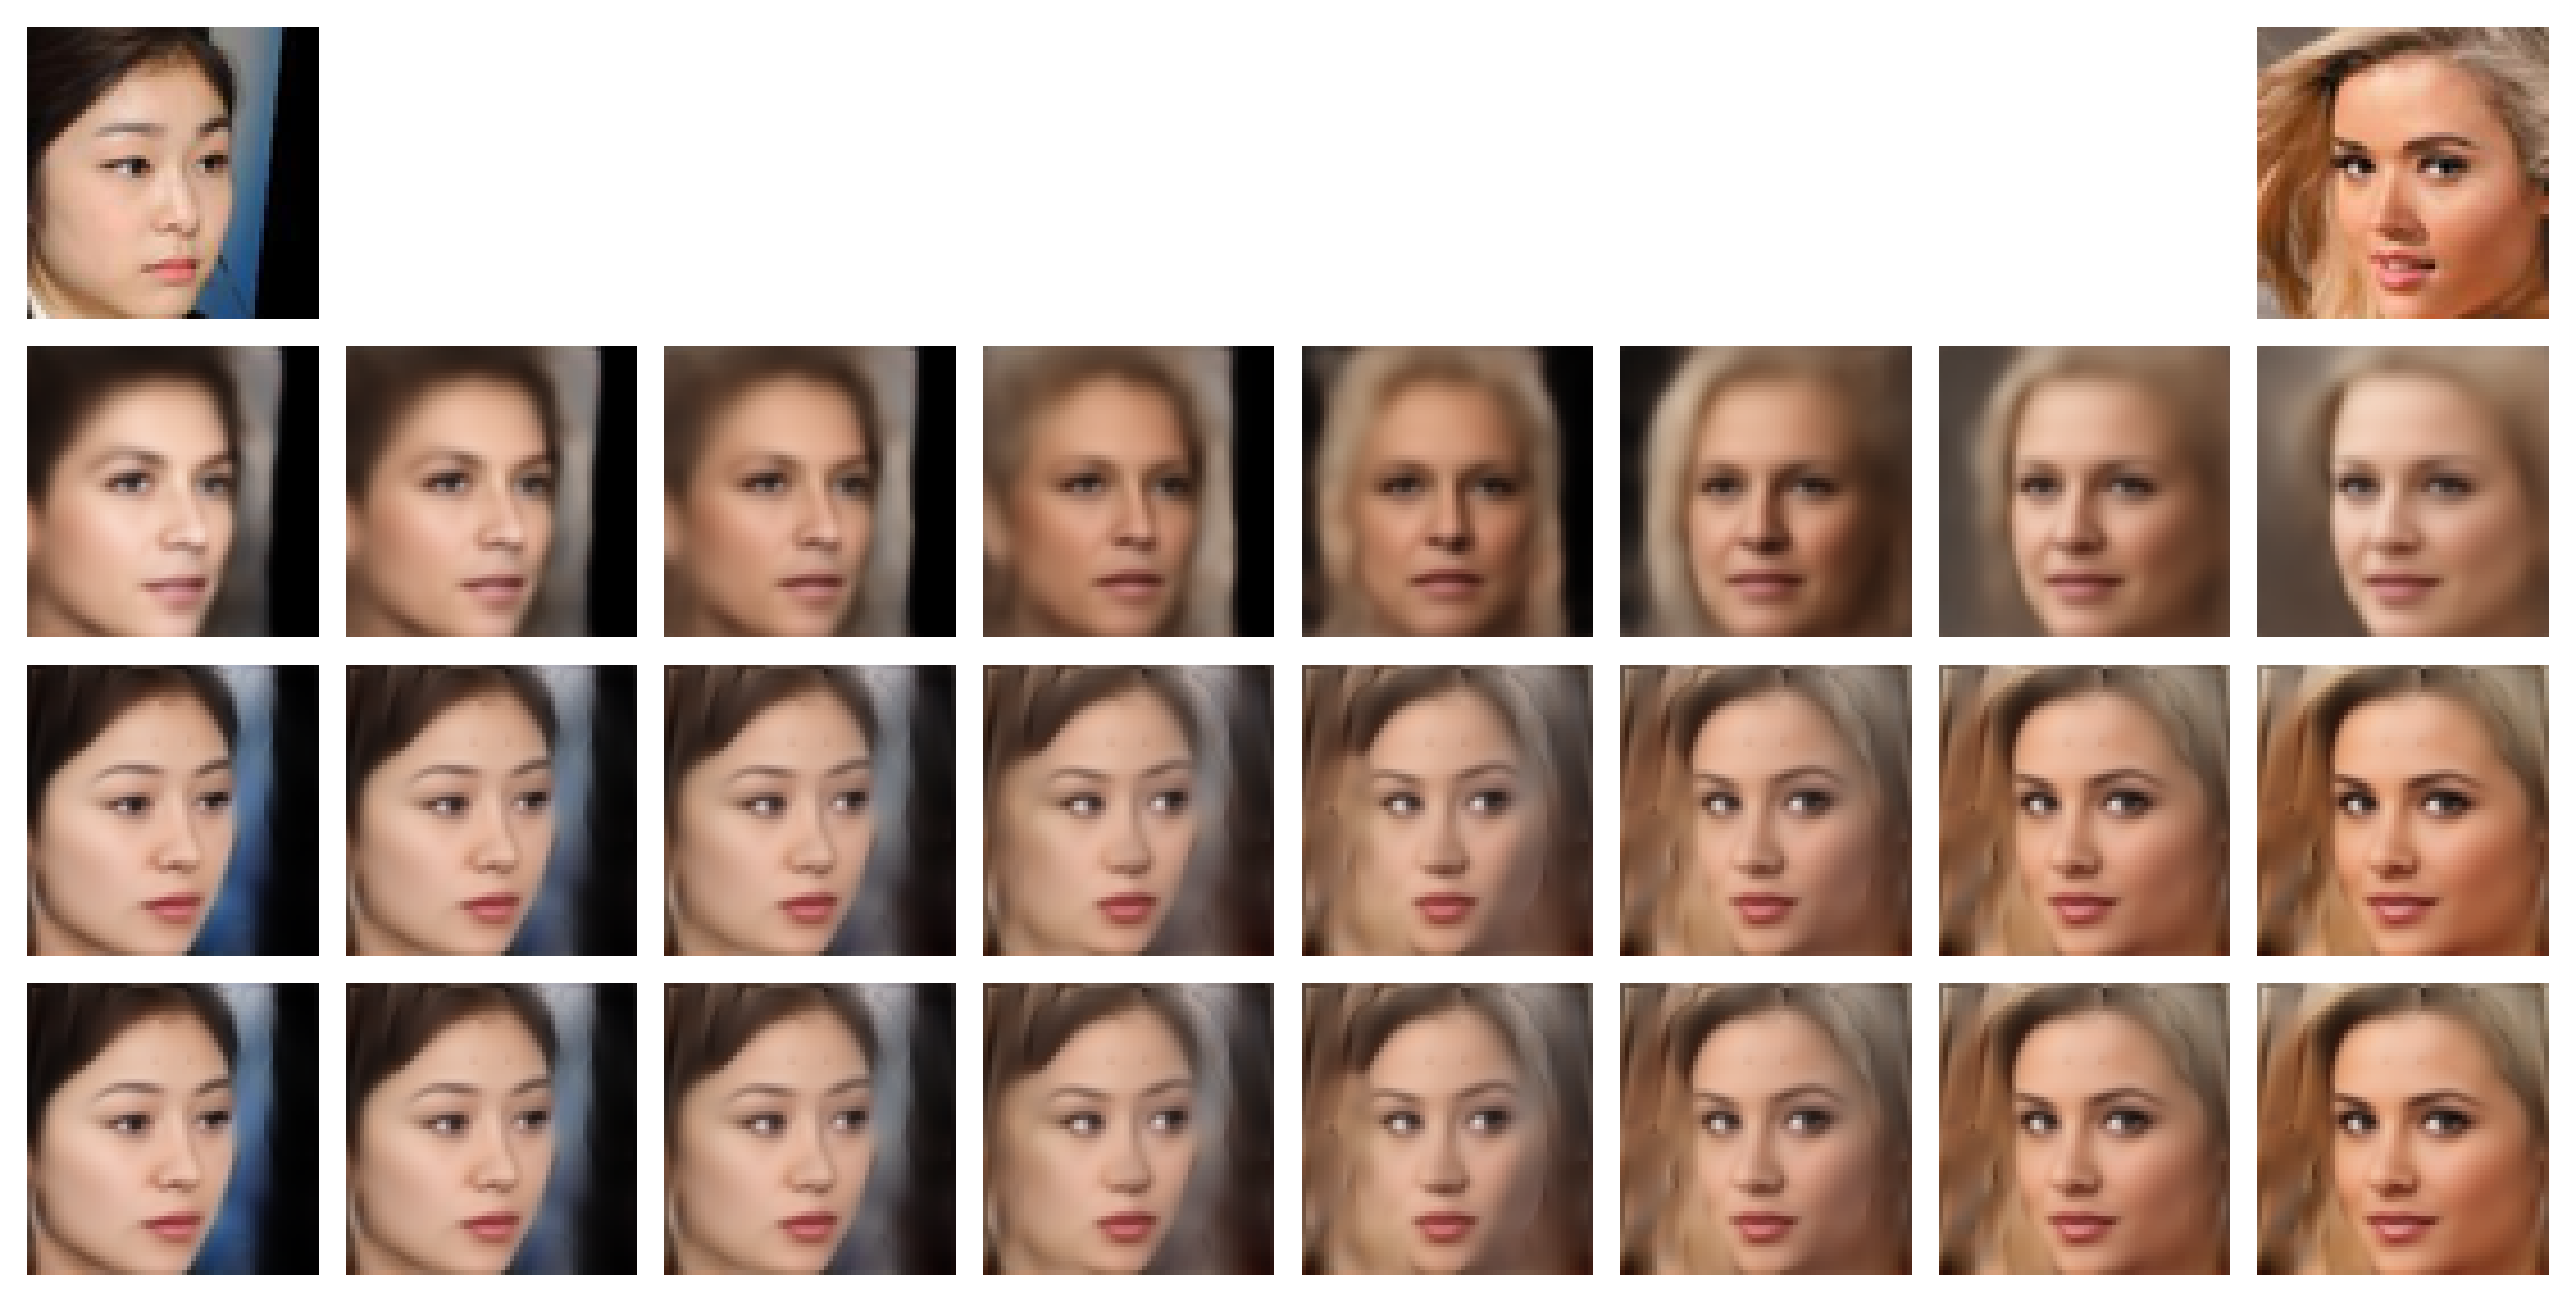

In [161]:
N = 8

s0 = test_set[19][0].expand((1,) + data_dim)
s1 = test_set[726][0].expand((1,) + data_dim)

recons = torch.cat([s0, torch.ones((N-2,) + data_dim) , s1])

for k in models:
    z0, _ = models[k].encode(s0.to(device))
    z1, _ = models[k].encode(s1.to(device))
    zs = torch.cat([n/(N-1) * z1 + (1-n/(N-1)) * z0 for n in range(N)])
    recon = models[k].decode(zs)
    recons = torch.cat([recons, recon.cpu()])

grid = torchvision.utils.make_grid(recons, nrow=N, padding=6, pad_value=1)
img = to_img(grid)

img.save('./comparison/celebA_interpolation1.png')

img

# Samples

In [101]:
N = 24
keys = list(models.keys())

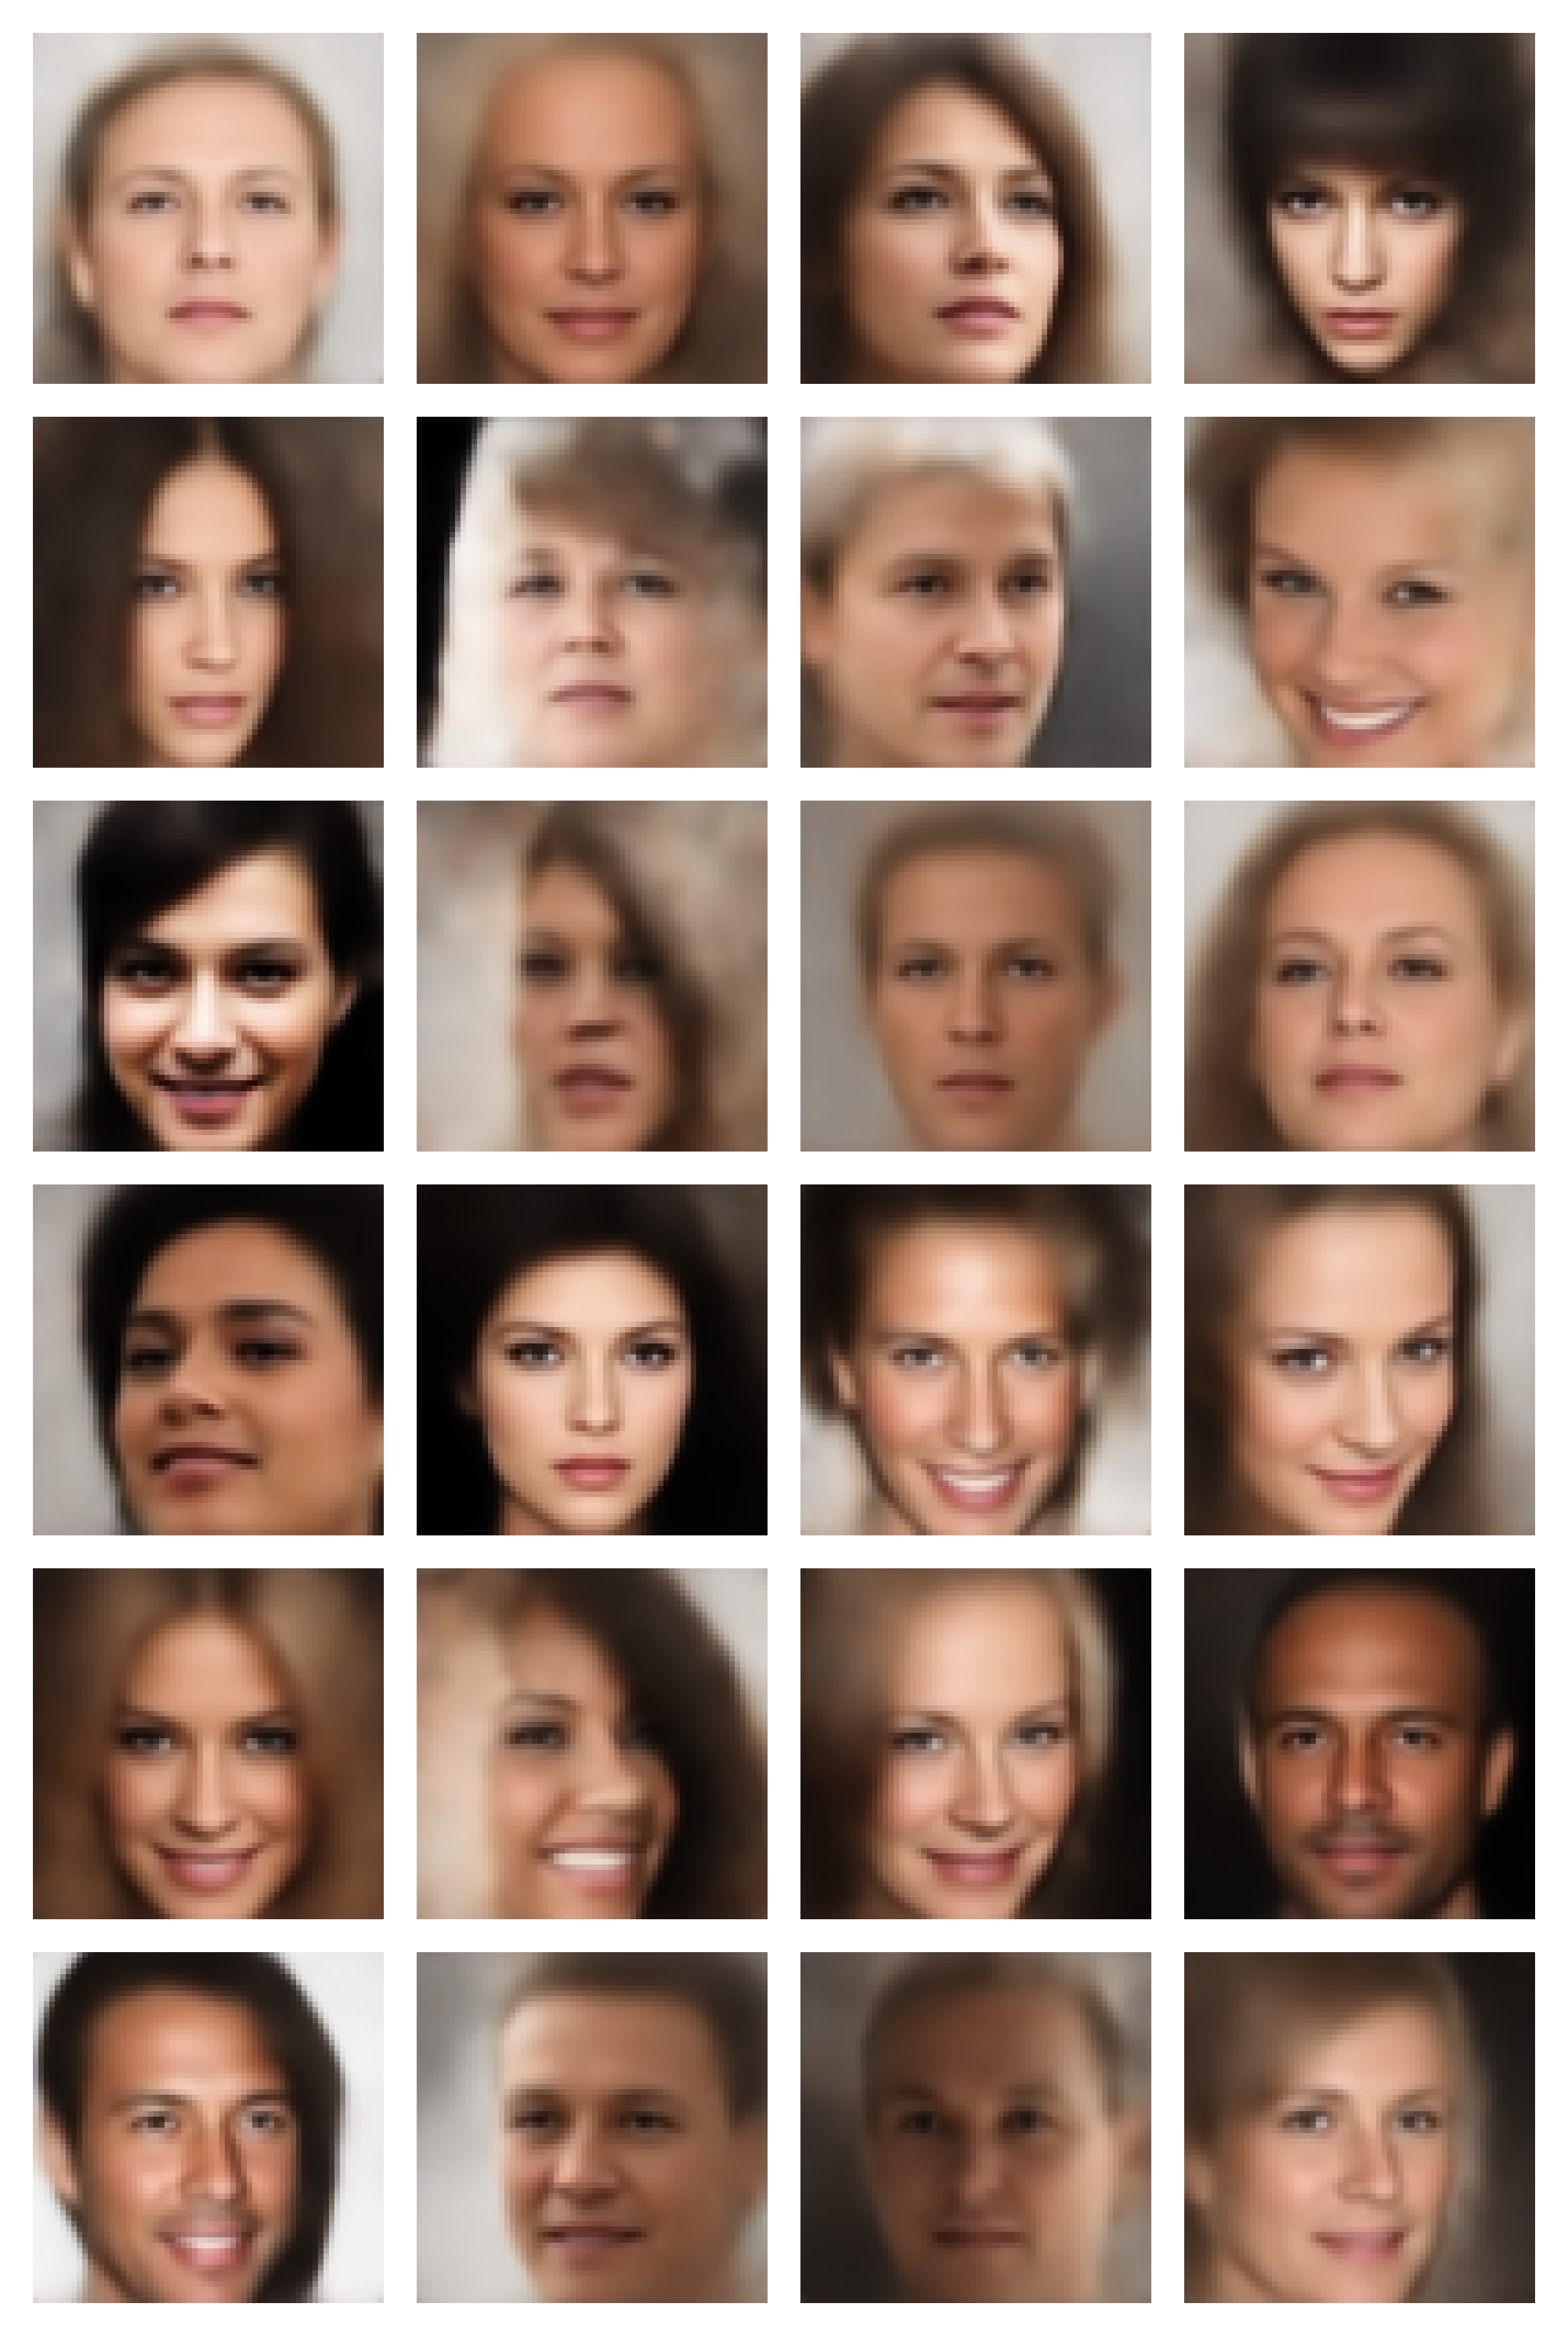

In [107]:
k = keys[0]
z = torch.randn(N, models[k].latent_space).to(device)
recon = models[k].decode(z).cpu()
grid = torchvision.utils.make_grid(recon, nrow=4, padding=6, pad_value=1)
img = to_img(grid)

img.save('./comparison/celebA_samples_{}.png'.format(k))
img

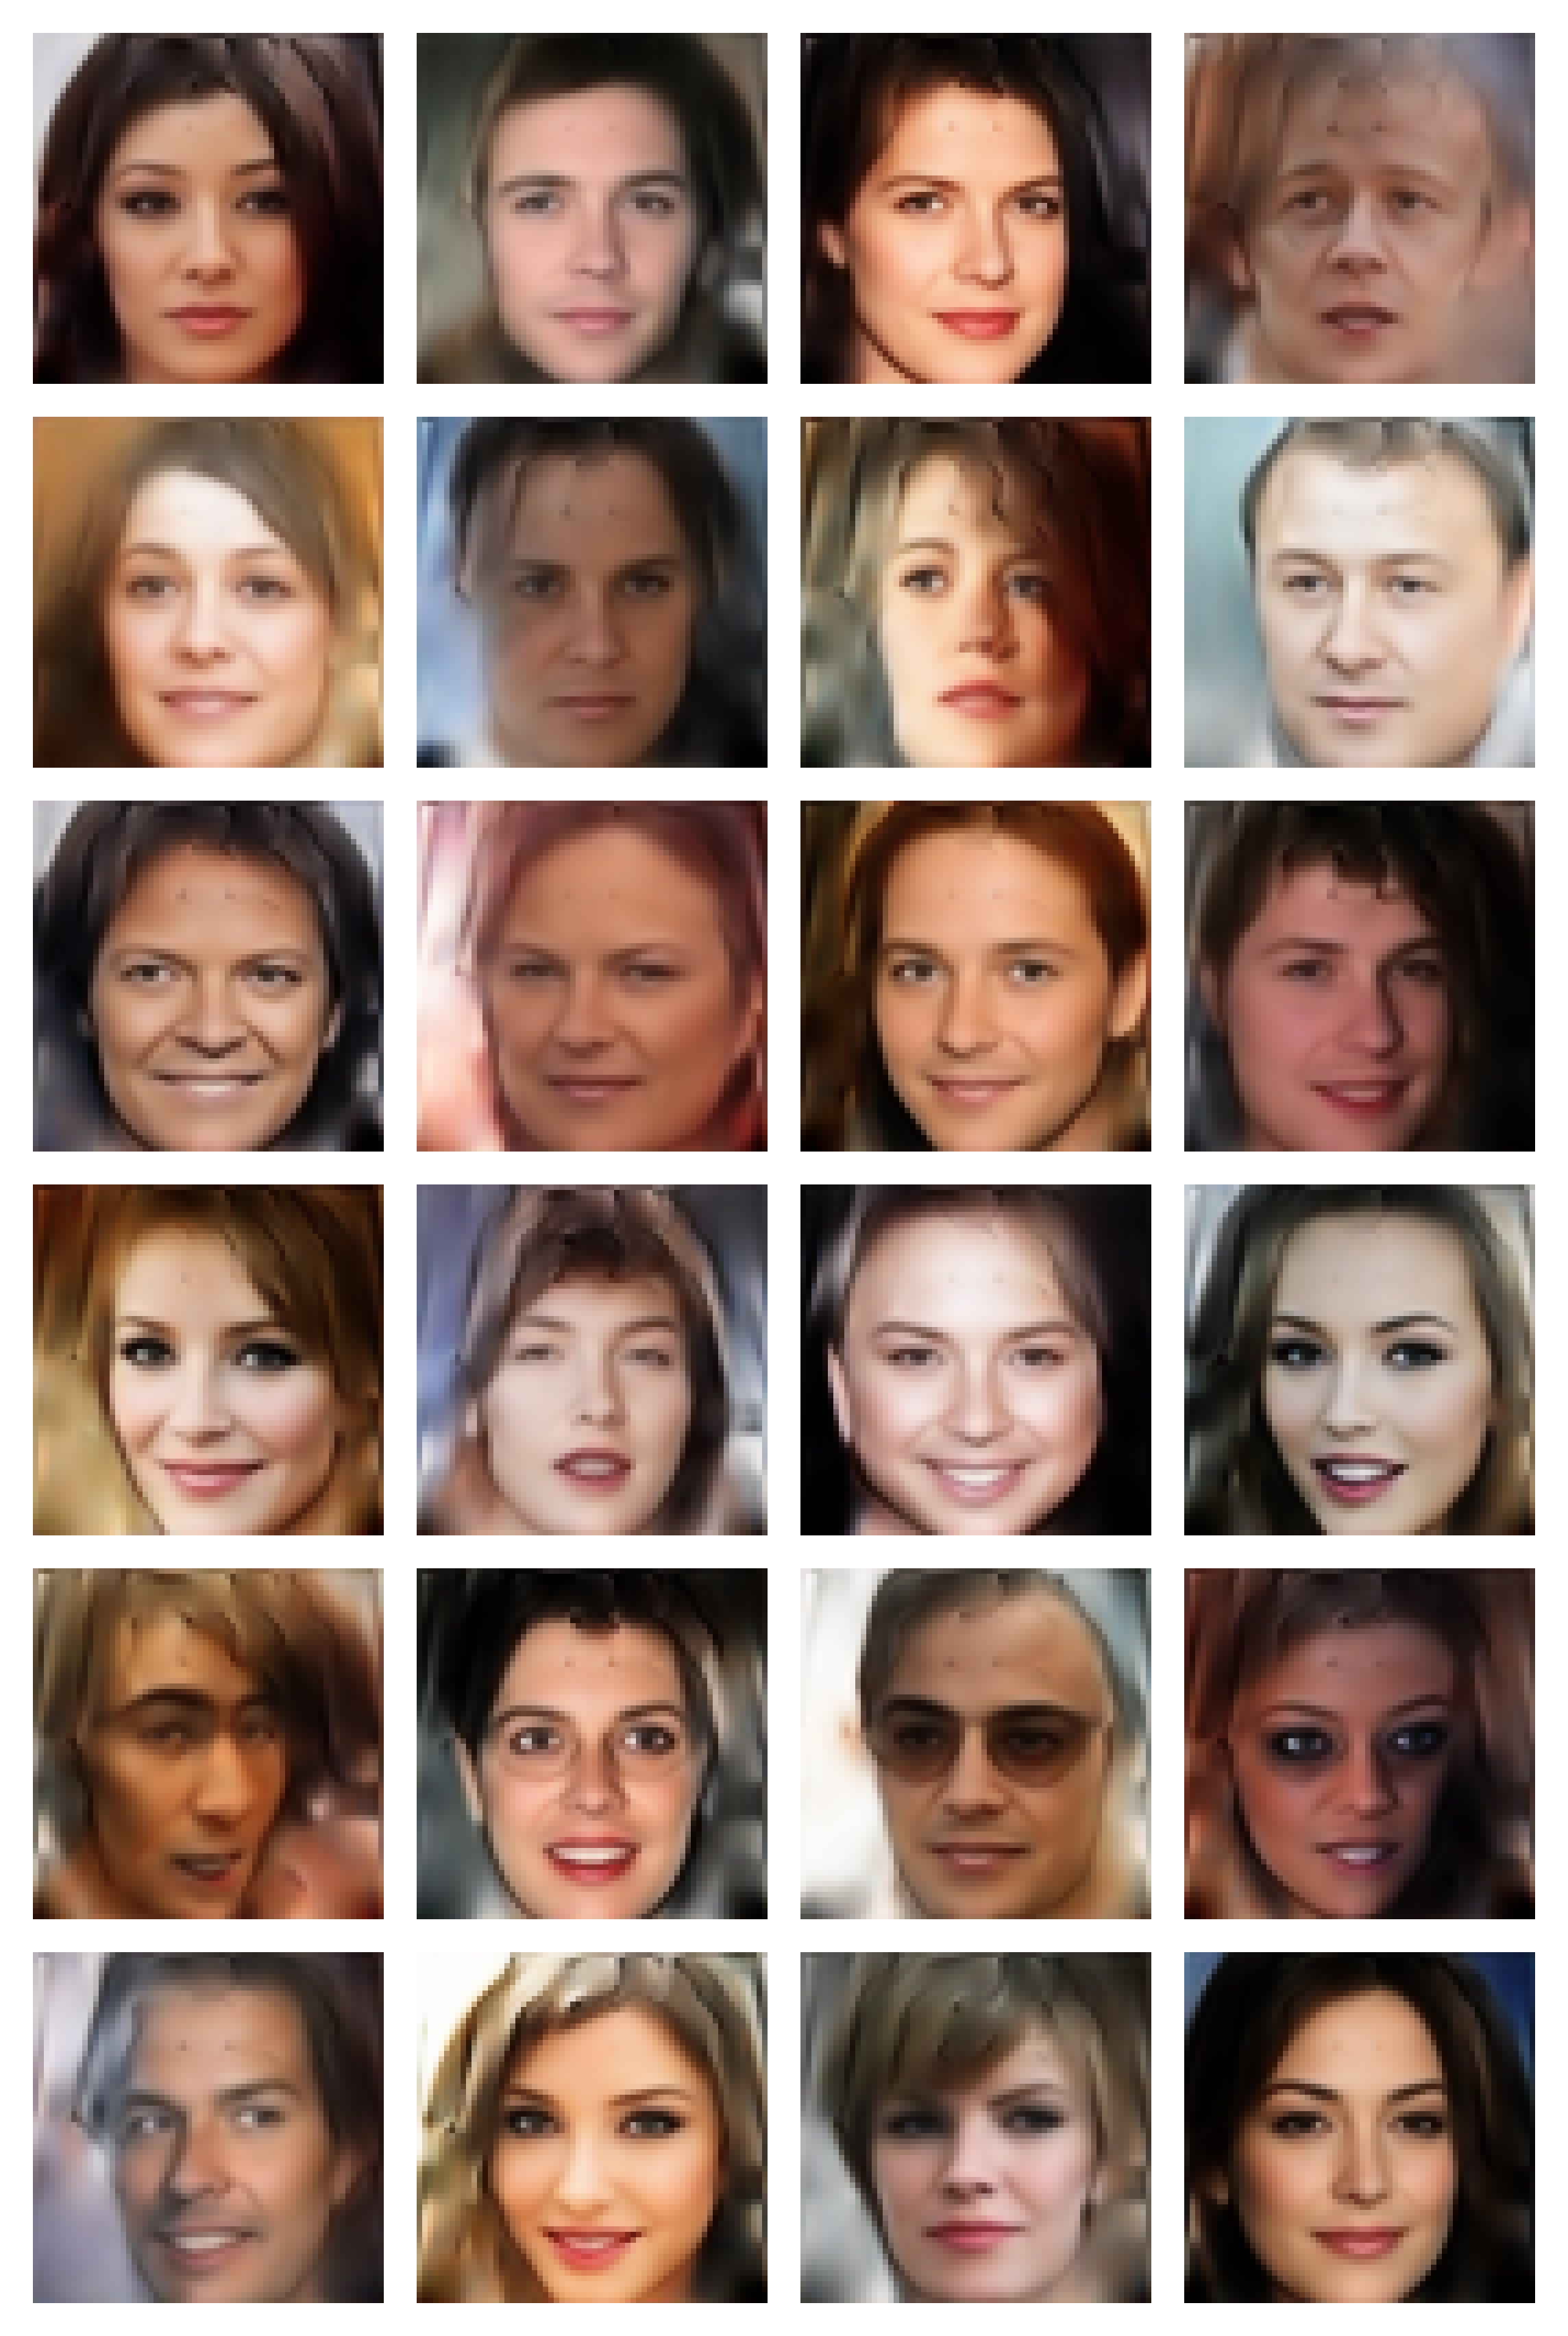

In [111]:
k = keys[1]
z = torch.randn(N, models[k].latent_space).to(device)
recon = models[k].decode(z).cpu()
grid = torchvision.utils.make_grid(recon, nrow=4, padding=6, pad_value=1)
img = to_img(grid)

img.save('./comparison/celebA_samples_{}.png'.format(k))
img

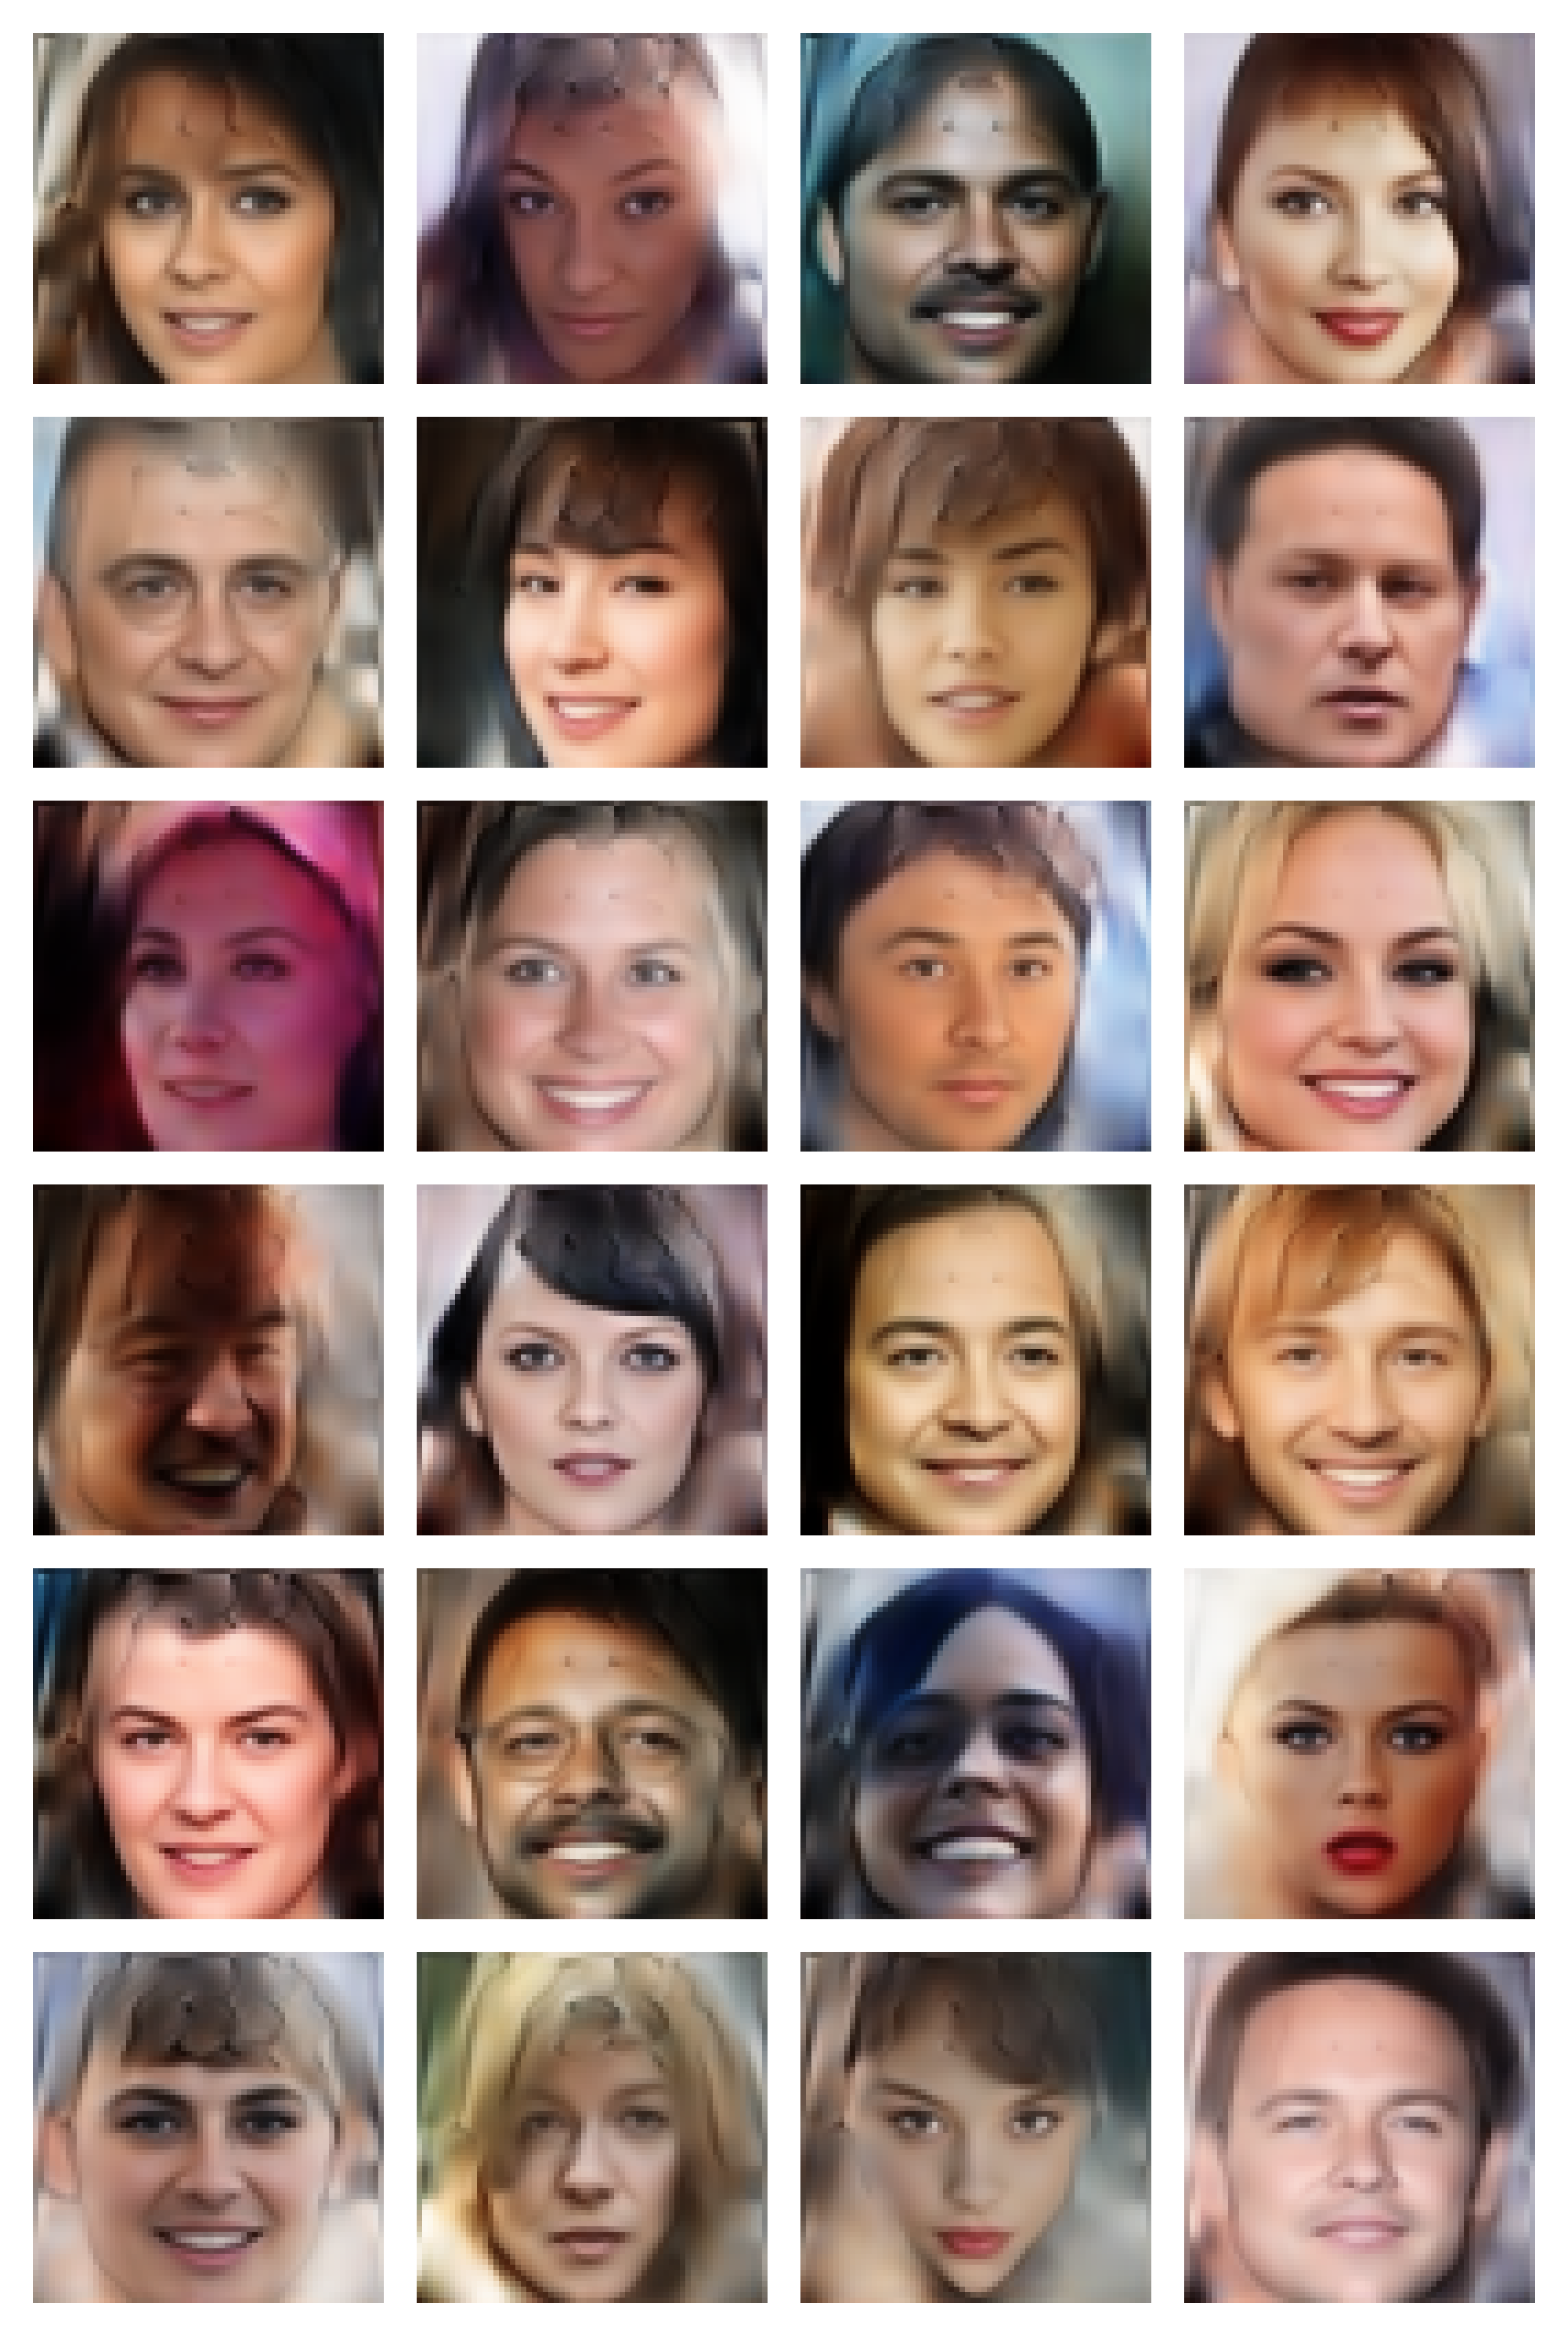

In [112]:
k = keys[2]
z = torch.randn(N, models[k].latent_space).to(device)
recon = models[k].decode(z).cpu()
grid = torchvision.utils.make_grid(recon, nrow=4, padding=6, pad_value=1)
img = to_img(grid)

img.save('./comparison/celebA_samples_{}.png'.format(k))
img

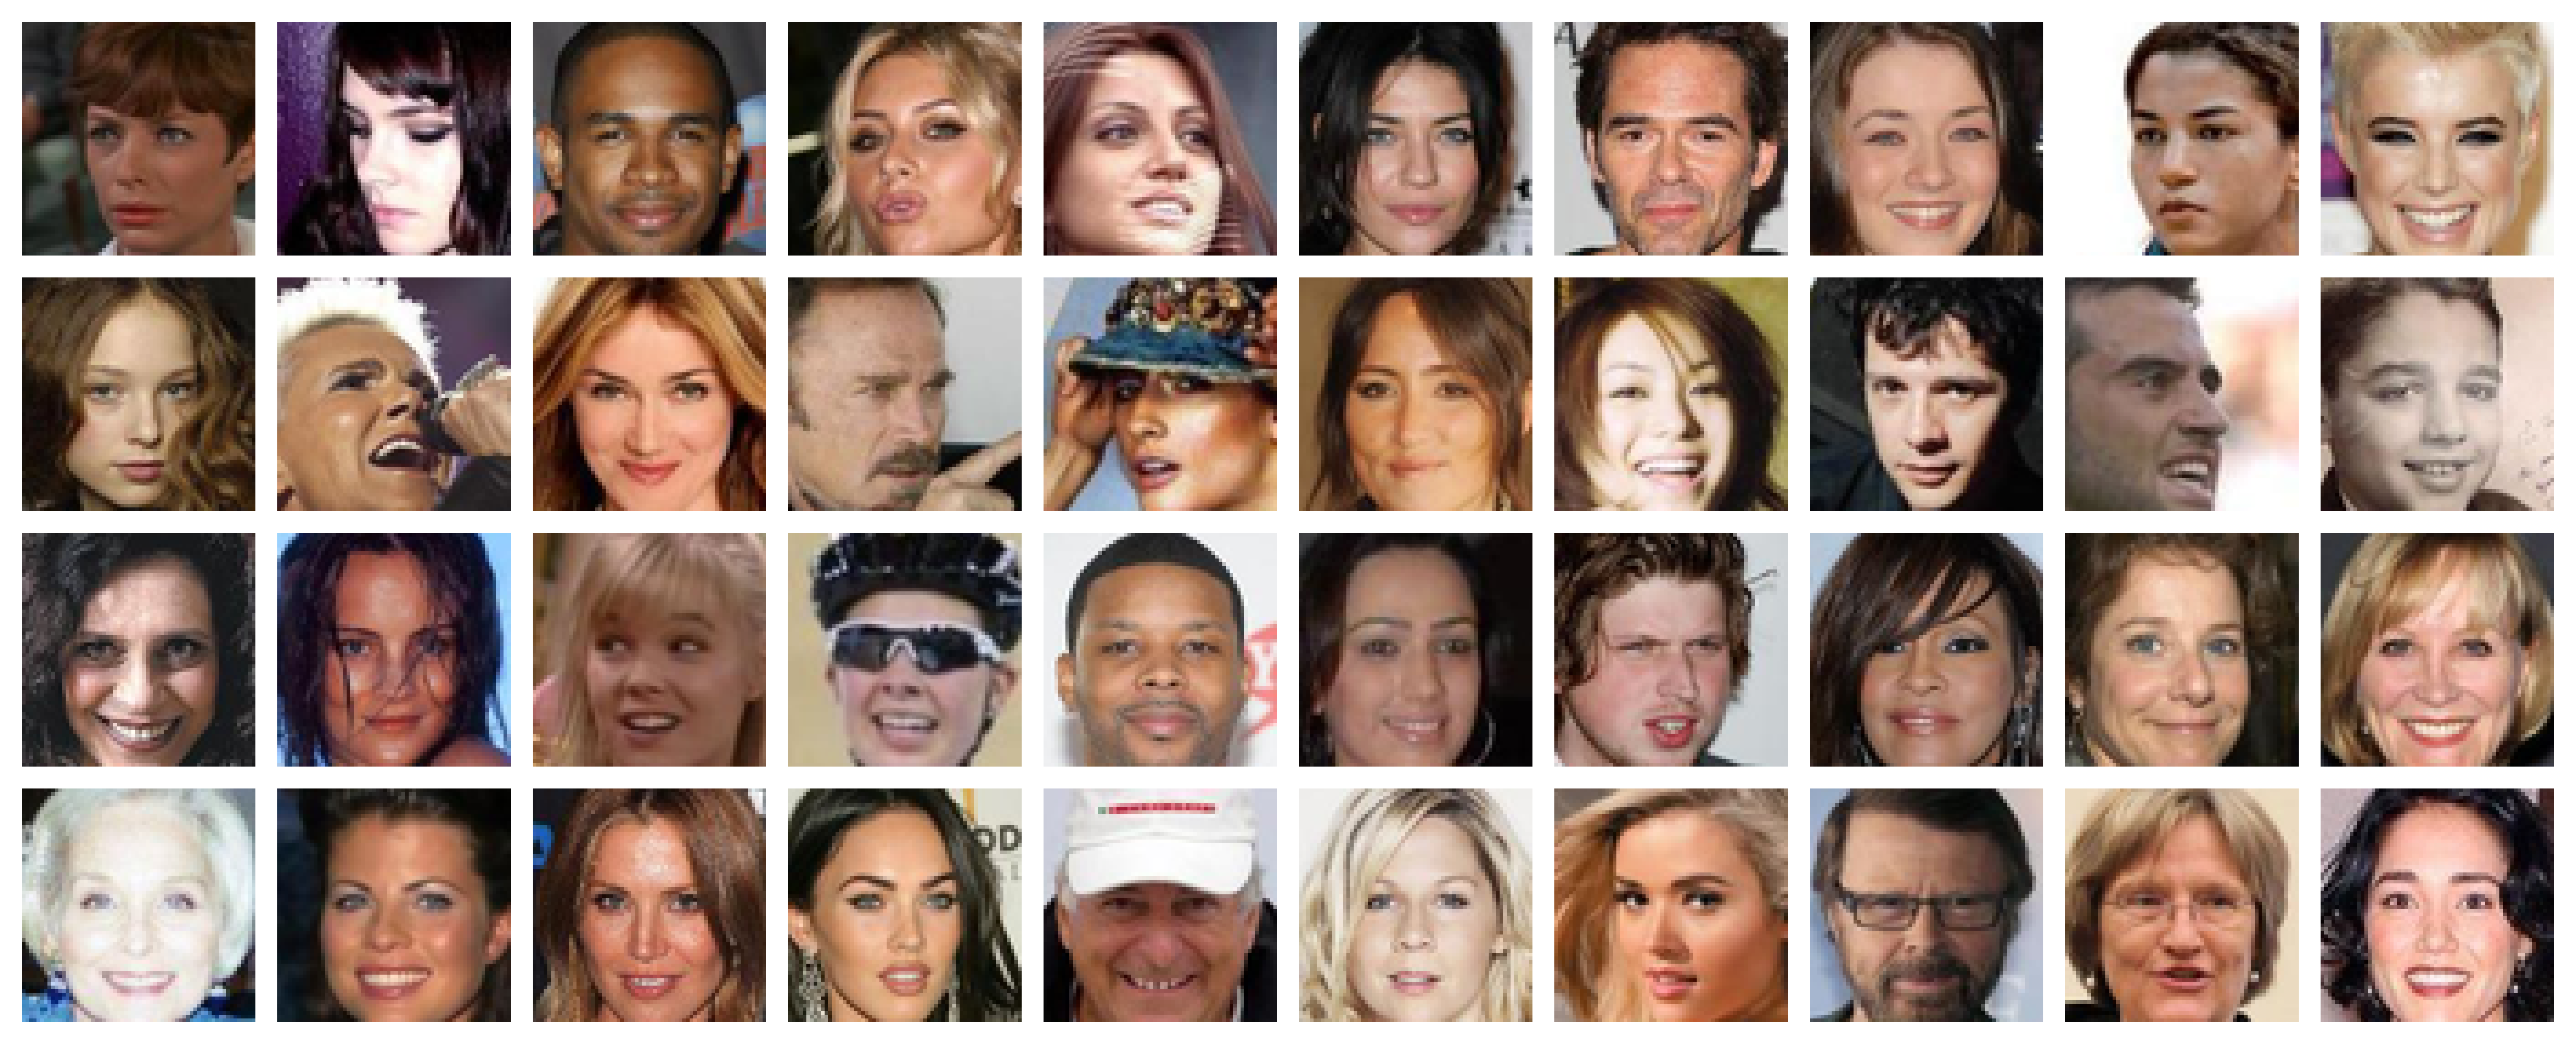

In [155]:
N = 40
#sample reference images
reference = torch.cat([test_set[i+690][0].expand((1,) + data_dim) for i in range(N)])

grid = torchvision.utils.make_grid(reference, nrow=10, padding=6, pad_value=1)
img = to_img(grid)

img